In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
active_losses = pd.read_csv('../data/Avtice-losses.csv', skiprows=1)
active_losses.head(3)

,Zeitstempel,kWh
0,2019-01-01 00:15:00,39143.346123
1,2019-01-01 00:30:00,32788.068958
2,2019-01-01 00:45:00,33018.915678


In [47]:
active_losses["MWh"] = active_losses["kWh"]/1000
active_losses.head(3)

,Zeitstempel,kWh,MWh
0,2019-01-01 00:15:00,39143.346123,39.143346
1,2019-01-01 00:30:00,32788.068958,32.788069
2,2019-01-01 00:45:00,33018.915678,33.018916


In [48]:
active_losses['Zeitstempel'] = pd.to_datetime(active_losses['Zeitstempel'])
active_losses.set_index('Zeitstempel', inplace=True)
active_losses.head(3)

,kWh,MWh
Zeitstempel,,
2019-01-01 00:15:00,39143.346123,39.143346
2019-01-01 00:30:00,32788.068958,32.788069
2019-01-01 00:45:00,33018.915678,33.018916


In [49]:
active_losses_agg = active_losses.resample('60T').sum()

In [50]:
active_losses_agg.head(3)

,kWh,MWh
Zeitstempel,,
2019-01-01 00:00:00,104950.330759,104.950331
2019-01-01 01:00:00,133772.192522,133.772193
2019-01-01 02:00:00,130398.024931,130.398025


<Axes: xlabel='Zeitstempel'>

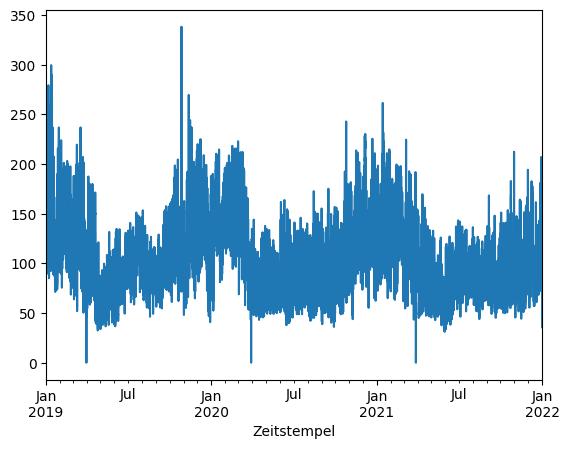

In [84]:
df_agg = active_losses_agg["MWh"]
df_agg.plot()

In [85]:
def df_to_X_y(df, window_size=168):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size-24+1):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size:i+window_size+24]
        y.append(label)
    return np.array(X), np.array(y)

In [86]:
WINDOW_SIZE = 168
X, y = df_to_X_y(df_agg, WINDOW_SIZE)
X.shape, y.shape

((26114, 168, 1), (26114, 24))

In [63]:
df_agg

Zeitstempel
2019-01-01 00:00:00    104.950331
2019-01-01 01:00:00    133.772193
2019-01-01 02:00:00    130.398025
2019-01-01 03:00:00    135.187545
2019-01-01 04:00:00    132.939009
                          ...    
2021-12-31 20:00:00    163.256620
2021-12-31 21:00:00    157.771329
2021-12-31 22:00:00    167.652363
2021-12-31 23:00:00    151.115196
2022-01-01 00:00:00     35.660212
Freq: 60T, Name: MWh, Length: 26305, dtype: float64

In [87]:
X_train, y_train = X[:21024], y[:21024]
X_val, y_val = X[21024:], y[21024:]

In [88]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((21024, 168, 1), (21024, 24), (5090, 168, 1), (5090, 24))

In [69]:
import torch

In [71]:
from torch.utils.data import DataLoader
import torch.nn as nn

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [89]:
# Angenommen, Ihre Daten sind Numpy-Arrays. Sie müssen sie zuerst in PyTorch-Tensoren umwandeln
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32)  # Annahme: batch_size ist 32
val_loader = DataLoader(val_dataset, batch_size=32)

# Fehlermaß (Absolute Mean Error) und Optimierer definieren
criterion = nn.L1Loss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [90]:
y_train

array([[151.48332093, 152.94484965, 163.26434375, ..., 147.09900366,
        163.28488091, 167.31776235],
       [152.94484965, 163.26434375, 182.58819492, ..., 163.28488091,
        167.31776235, 174.63731323],
       [163.26434375, 182.58819492, 185.32857604, ..., 167.31776235,
        174.63731323, 170.45231208],
       ...,
       [ 75.84653444,  56.60922151,  49.44655644, ...,  60.71544658,
         98.70413171, 113.11399736],
       [ 56.60922151,  49.44655644,  47.58020122, ...,  98.70413171,
        113.11399736,  78.885528  ],
       [ 49.44655644,  47.58020122,  45.94756551, ..., 113.11399736,
         78.885528  ,  55.72548475]])

In [91]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # LSTM Schicht: Eingang hat Größe 1 und Ausgang hat Größe 64
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        # Vollverbundene Schicht (Dense) mit ReLU-Aktivierung
        self.fc1 = nn.Linear(64, 8)
        self.relu = nn.ReLU()
        # Ausgabeschicht mit linearer Aktivierung, die 24 Vorhersagen erzeugt
        self.fc2 = nn.Linear(8, 24)

    def forward(self, x):
        # Durchlaufen der LSTM-Schicht
        lstm_out, _ = self.lstm(x)
        # Wir nehmen nur das letzte Ausgabeelement für die nächsten Schichten
        x = lstm_out[:, -1, :]
        # Durchlaufen der ersten vollverbundenen Schicht
        x = self.relu(self.fc1(x))
        # Durchlaufen der zweiten vollverbundenen Schicht (Ausgabeschicht)
        x = self.fc2(x)
        return x

In [92]:
model1 = MyModel()
print(model1)

MyModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=24, bias=True)
)


In [ ]:
# Bestes Modell speichern
best_val_loss = float('inf')

for epoch in range(10):  # 10 Epochen
    # Training
    model1.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model1(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model1(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        if not os.path.exists('model1'):
            os.makedirs('model1')
        torch.save(model1.state_dict(), 'model1/best_model.pth')